In [1]:
# Import necessary libraries
from fastai.vision.all import *
import pandas as pd
import torch
from torch import nn
from torchvision.models import resnet34
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
 pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu12x

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu12x
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())




PyTorch Version: 2.5.0+cu118
CUDA Available: True
CUDA Version: 11.8
Number of GPUs: 1


In [2]:

# Load the labels CSV
labels_df = pd.read_csv("C:\\Users\\alame\\Desktop\\pro edition\\deep learning\\AutoMania\\Supervised\\data\\combined_train\\combined_controls.csv")

# Path to images
path = Path('C:\\Users\\alame\\Desktop\\pro edition\\deep learning\\AutoMania\\Supervised\\data\\combined_train')

# Perform Exploratory Data Analysis (EDA)

In [3]:
# Cell 1: Display first few rows of the dataset
print("First few rows of the labels dataset:")
print(labels_df.head())

First few rows of the labels dataset:
         frame  left  right  forward  backward
0  frame_0.jpg     0      0        1         0
1  frame_1.jpg     0      0        1         0
2  frame_2.jpg     0      0        1         0
3  frame_3.jpg     0      0        1         0
4  frame_4.jpg     0      0        1         0


In [4]:
# Cell 2: Summary statistics of the dataset
print("\nSummary statistics of the dataset:")
print(labels_df.describe())




Summary statistics of the dataset:
               left         right       forward      backward
count  13603.000000  13603.000000  13603.000000  13603.000000
mean       0.144159      0.149746      0.747335      0.018966
std        0.351264      0.356836      0.434556      0.136411
min        0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.000000
50%        0.000000      0.000000      1.000000      0.000000
75%        0.000000      0.000000      1.000000      0.000000
max        1.000000      1.000000      1.000000      1.000000


In [5]:
# Cell 3: Count of each control action
print("\nCount of each control action:")
control_counts = labels_df[['left', 'right', 'forward', 'backward']].sum()
print(control_counts)




Count of each control action:
left         1961
right        2037
forward     10166
backward      258
dtype: int64


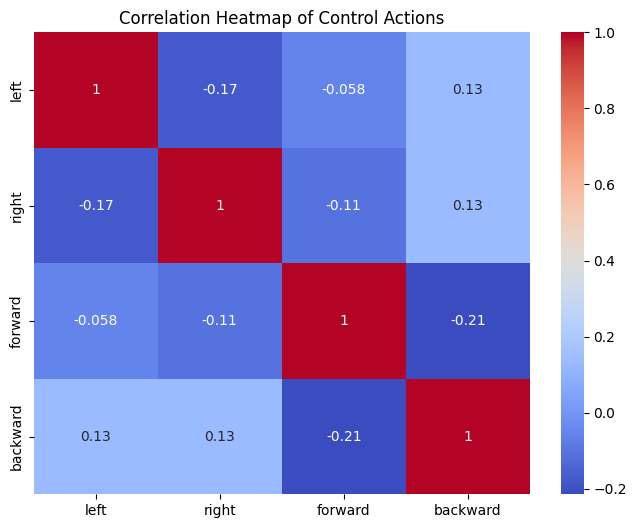

In [6]:
# Cell 5: Correlation heatmap of control actions
plt.figure(figsize=(8, 6))
sns.heatmap(labels_df[['left', 'right', 'forward', 'backward']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Control Actions')
plt.show()

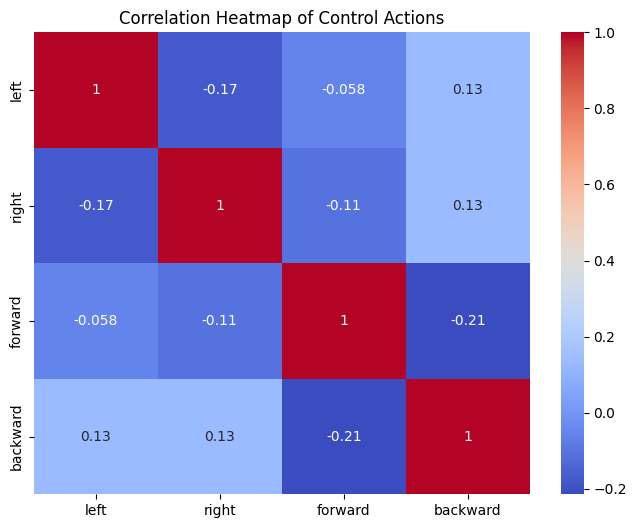

In [7]:
# Cell 5: Correlation heatmap of control actions
plt.figure(figsize=(8, 6))
sns.heatmap(labels_df[['left', 'right', 'forward', 'backward']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Control Actions')
plt.show()

In [ ]:
from fastai.vision.all import *
import pandas as pd
import torch
from torch import nn
from torchvision.models import resnet18

# Load the labels CSV
labels_df = pd.read_csv("C:\\Users\\alame\\Desktop\\pro edition\\deep learning\\AutoMania\\Supervised\\data\\combined_train\\combined_controls.csv")

# Path to images
path = Path('C:\\Users\\alame\\Desktop\\pro edition\\deep learning\\AutoMania\\Supervised\\data\\combined_train')

# Define a function to get the control inputs (left, right, forward, backward)
def get_y(row):
    labels = []
    if row['left'] == 1: labels.append('left')
    if row['right'] == 1: labels.append('right')
    if row['forward'] == 1: labels.append('forward')
    if row['backward'] == 1: labels.append('backward')
    return labels

def get_x(row):
    img_path = path / row['frame']
    img = PILImage.create(img_path)
    return img  # No cropping applied

# DataBlock for regression task
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),  # Images as input, binary labels as output
    get_x=get_x,  # Get image path
    get_y=get_y,  # Get control inputs as a tensor
    splitter=RandomSplitter(valid_pct=0.2),  # Split train/validation
    item_tfms=Resize((395, 222)),  # Resize images to the required dimensions
    batch_tfms=aug_transforms(  # Apply realistic augmentations during training
        flip_vert=False,          # Do not flip vertically
        max_rotate=2.0,           # Allow small rotations (up to 5 degrees)
        max_zoom=1.02,            # Slight zoom in/out (5% zoom)
        max_warp=0.1,             # Apply small perspective warps
        p_affine=0.75,            # Probability of applying affine transforms (rotation/zoom)
        p_lighting=0.3           # Probability of applying lighting transformations (brightness/contrast)
    )
)

# Create DataLoaders
dls = dblock.dataloaders(labels_df, bs=8)

# Define the CNN + LSTM model using ResNet18
class ResNetLSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Load a pretrained ResNet18 model
        self.resnet = resnet18(weights='IMAGENET1K_V1')
        # Remove the last fully connected layer of ResNet18
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        # LSTM to capture temporal dependencies
        self.lstm = nn.LSTM(input_size=512, hidden_size=256, num_layers=3, batch_first=True, dropout=0.5)
        # Fully connected layer for final prediction
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout added here
            nn.Linear(128, 4)  # Predicting left, right, forward, backward
        )

    def forward(self, x):
        # Expecting input of shape (batch_size, C, H, W)
        batch_size = x.size(0)
        
        # Extract features from the image using ResNet18
        frame_features = self.resnet(x)  # Shape: (batch_size, 512, 1, 1)
        frame_features = frame_features.view(batch_size, 1, -1)  # Shape: (batch_size, 1, 512)
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(frame_features)  # Shape: (batch_size, 1, 256)
        
        # Take the output of the LSTM cell
        output = lstm_out[:, -1, :]  # Shape: (batch_size, 256)
        
        # Fully connected layer to get final prediction
        output = self.fc(output)  # Shape: (batch_size, 4)
        
        return output

# Instantiate the model
model = ResNetLSTMModel()

# Use BCEWithLogitsLoss for multi-label binary classification
pos_weight = torch.tensor([2.0, 2.0, 0.5, 3.0])  # Adjust based on the imbalance
loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Create Learner and move model to GPU
learn = Learner(dls, model, loss_func=loss_func, metrics=[accuracy_multi], wd=5e-4).to_fp16()

# Training with frozen ResNet layers
print("Training the model with frozen ResNet layers")
learn.freeze()
learn.fit_one_cycle(7, slice(1e-5, 1e-3))  # Training with frozen layers

# Unfreeze the model for fine-tuning
print("Fine-tuning the model with all layers")
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, 1e-4))  # Fine-tuning with all layers unfrozen

# Evaluate the model
print("Evaluating the model on validation set")
learn.validate()

# Save the trained model
learn.export('trackmania_car_detection_model.pkl')


Training the model with frozen ResNet layers


C:\Users\alame\AppData\Roaming\Python\Python312\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
C:\Users\alame\AppData\Roaming\Python\Python312\site-packages\torch\amp\autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\alame\AppData\Roaming\Python\Python312\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
C:\Users\alame\AppData\Roaming\Python\Python312\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  D

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.497148,0.483678,0.860478,41:37
1,0.506462,0.483290,0.860478,42:29
2,0.499469,0.483664,0.860478,28:45


In [74]:
print(f"Input tensor shape: {learn.dls.train.one_batch()[0].shape}")
print(f"Target tensor shape: {learn.dls.train.one_batch()[1].shape}")




Input tensor shape: torch.Size([64, 3, 224, 224])
Target tensor shape: torch.Size([64, 4])


C:\Users\alame\AppData\Roaming\Python\Python312\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=devic

SuggestedLRs(valley=0.0020892962347716093)

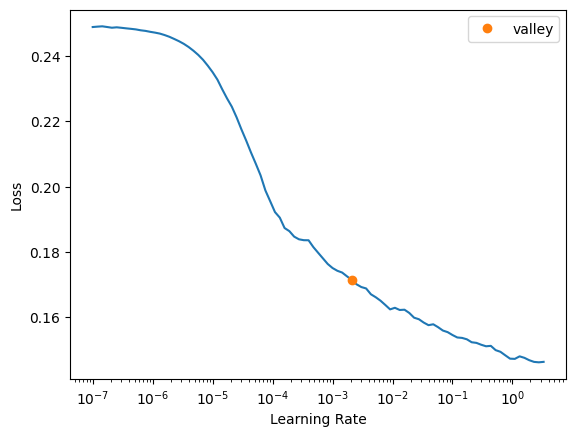

In [69]:
# Step 8: Find the optimal learning rate
learn.lr_find()
# Use the valley learning rate from the plot

In [ ]:
from fastai.vision.all import *
import pandas as pd
import torch
from torch import nn
from torchvision.models import resnet18

# Load the labels CSV
labels_df = pd.read_csv("C:\\Users\\alame\\Desktop\\pro edition\\deep learning\\AutoMania\\Supervised\\data\\combined_train\\combined_controls.csv")

# Path to images
path = Path('C:\\Users\\alame\\Desktop\\pro edition\\deep learning\\AutoMania\\Supervised\\data\\combined_train')

def crop_car(img):
    width, height = img.size
    left = (width - 200) / 2  # Crop 200 pixels wide centered horizontally
    right = (width + 200) / 2
    top = (height - 50) / 2  # Crop 50 pixels tall centered vertically
    bottom = (height + 50) / 2
    return img.crop((left, top, right, bottom))  # Crop the image

# Define a function to get the control inputs (left, right, forward, backward)
def get_y(row):
    labels = []
    if row['left'] == 1: labels.append('left')
    if row['right'] == 1: labels.append('right')
    if row['forward'] == 1: labels.append('forward')
    if row['backward'] == 1: labels.append('backward')
    return labels

def get_x(row):
    img_path = path / row['frame']
    img = PILImage.create(img_path)
    return crop_car(img)  # Crop the image to focus on the car

# DataBlock for regression task
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),  # Images as input, binary labels as output
    get_x=get_x,  # Get image path
    get_y=get_y,  # Get control inputs as a tensor
    splitter=RandomSplitter(valid_pct=0.2),  # Split train/validation
    item_tfms=Resize((395, 222)),  # Resize images to the required dimensions
    batch_tfms=aug_transforms(  # Apply realistic augmentations during training
        flip_vert=False,          # Do not flip vertically
        max_rotate=2.0,           # Allow small rotations (up to 5 degrees)
        max_zoom=1.02,            # Slight zoom in/out (5% zoom)
        max_warp=0.1,             # Apply small perspective warps
        p_affine=0.75,            # Probability of applying affine transforms (rotation/zoom)
        p_lighting=0.3           # Probability of applying lighting transformations (brightness/contrast)
      
    )

)

# Create DataLoaders
dls = dblock.dataloaders(labels_df, bs=16)

# Define the CNN + LSTM model
class ResNetLSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Load a pretrained ResNet50 model
        self.resnet = resnet18(weights='IMAGENET1K_V1')
        # Remove the last fully connected layer of ResNet50
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        # LSTM to capture temporal dependencies
        self.lstm = nn.LSTM(input_size=2048, hidden_size=1024, num_layers=3, batch_first=True, dropout=0.5)
        # Fully connected layer for final prediction
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout added here
            nn.Linear(512, 4)  # Predicting left, right, forward, backward
        )
        
    def forward(self, x):
        # Expecting input of shape (batch_size, C, H, W)
        batch_size = x.size(0) 
        
        # Extract features from the image using ResNet50
        frame_features = self.resnet(x)  # Shape: (batch_size, 2048, 1, 1)
        frame_features = frame_features.view(batch_size, 1, -1)  # Shape: (batch_size, 1, 2048)
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(frame_features)  # Shape: (batch_size, 1, 512)
        
        # Take the output of the LSTM cell
        output = lstm_out[:, -1, :]  # Shape: (batch_size, 512)
        
        # Fully connected layer to get final prediction
        output = self.fc(output)  # Shape: (batch_size, 4)
        
        return output

if __name__ == "__main__":
# Instantiate the model
    model = ResNetLSTMModel()

# Use BCEWithLogitsLoss for multi-label binary classification
    loss_func = nn.BCEWithLogitsLoss()

# Add L2 Regularization (weight decay) for better generalization

    pos_weight = torch.tensor([2.0, 2.0, 0.5, 3.0])  # Adjust based on the imbalance
    loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    learn = Learner(dls, model, loss_func=loss_func, metrics=[accuracy_multi], wd=5e-4)

    # Training with frozen ResNet layers
    print("Training the model with frozen ResNet layers")
    learn.freeze()
    learn.fit_one_cycle(7, slice(1e-5, 1e-3))  # Training with frozen layers

    # Unfreeze the model for fine-tuning
    print("Fine-tuning the model with all layers")
    learn.unfreeze()
    learn.fit_one_cycle(5, slice(1e-5, 1e-4))  # Fine-tuning with all layers unfrozen

    # Evaluate the model
    print("Evaluating the model on validation set")
    learn.validate()

    # Save the trained model
    learn.export('trackmania_car_detection_model.pkl')
